In [ ]:
#!pip install requests
#!pip install imbalanced-learn

In [ ]:
#########################
#### Packages needed ####
#########################

## Basics
import pandas as pd
import numpy as np
import re
import time
import warnings 

## Exctracting Lyrics & getting data in shape
from functions import get_lyrics, list_to_chunks, most_occ_words, train_model, predict
from bs4 import BeautifulSoup
import requests
from itertools import chain
from random import shuffle
RANDOM_STATE = 42

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from statistics import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB  # for count data like the one we have with the words in texts
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline

import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix

# Balancing out the dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [5]:
# extract html
url = "https://www.lyrics.com/artist/"

artists = ["Arctic-Monkeys", "Cardi-B", "Kevin-Abstract", "Frank-Ocean", "Doja-Cat" ]

In [6]:
#using the keys:values
artists = ["Arctic-Monkeys", "Cardi-B", "Kevin-Abstract", "Frank-Ocean", "Doja-Cat" ]
urls = ["https://www.lyrics.com/artist/Arctic-Monkeys/744567", "https://www.lyrics.com/artist/Cardi-B/3195462", "https://www.lyrics.com/artist/Kevin-Abstract/3164803", "https://www.lyrics.com/artist/Frank-Ocean/2295304", "https://www.lyrics.com/artist/Doja-Cat/605"]

artists_urls = dict(zip(artists, urls))
artists_urls

html_artists_dir = []
for artist, link in artists_urls.items():
    #url_artists_temp = f"{url}{artist}"
    print(link)
    result = requests.get(link).text
    html_artists_dir.append(result)


https://www.lyrics.com/artist/Arctic-Monkeys/744567
https://www.lyrics.com/artist/Cardi-B/3195462
https://www.lyrics.com/artist/Kevin-Abstract/3164803
https://www.lyrics.com/artist/Frank-Ocean/2295304
https://www.lyrics.com/artist/Doja-Cat/605


In [7]:
# initialise bs4
song_links = []
titles = []
artist_name = []

for artist in html_artists_dir:
    artist_soup = BeautifulSoup(artist)
    
    songs_links_soup = artist_soup.find_all(class_= "tal qx")
    
    links = [link.a["href"] for link in songs_links_soup]
    song_links = song_links + links
    
    for i in songs_links_soup:
        titles.append(i.text)
    
    for i in links:
        artist = i.split("/", 5)[-2].replace("+"," ")
        artist_name.append(artist)

In [8]:
music_df = pd.DataFrame({"Artist": artist_name, "Titels": titles, "Link": song_links})
music_df['Link'] = 'https://www.lyrics.com' + music_df['Link'].astype(str)
music_df

,Artist,Titels,Link
0,Arctic Monkeys,Star Treatment,https://www.lyrics.com/lyric/34972023/Arctic+M...
1,Arctic Monkeys,One Point Perspective,https://www.lyrics.com/lyric/34972022/Arctic+M...
2,Arctic Monkeys,American Sports,https://www.lyrics.com/lyric/34972021/Arctic+M...
3,Arctic Monkeys,Tranquility Base Hotel + Casino,https://www.lyrics.com/lyric/34972020/Arctic+M...
4,Arctic Monkeys,Golden Trunks,https://www.lyrics.com/lyric/34972019/Arctic+M...
...,...,...,...
984,Doja Cat,Woman,https://www.lyrics.com/lyric/38585388/Doja+Cat...
985,Doja Cat,Ain't Shit,https://www.lyrics.com/lyric/38585392/Doja+Cat...
986,Doja Cat,BMO [Remix],https://www.lyrics.com/lyric/36984707/Doja+Cat...
987,Doja Cat,Pussy Talk,https://www.lyrics.com/lyric/37326455/Doja+Cat...


In [9]:
# Create a dataframe containing the lyrics for the artists songs of the given dataset
lyrics = get_lyrics(music_df)

music_df["Lyrics"] = pd.DataFrame({"Lyrics": lyrics})
music_df  

0 success!
1 success!
2 success!
3 success!
4 success!
5 success!
6 success!
7 success!
8 success!
9 success!
10 success!
11 success!
12 success!
13 success!
14 success!
15 success!
16 success!
17 success!
18 success!
19 success!
20 success!
21 success!
22 success!
23 success!
24 success!
25 success!
26 success!
27 success!
28 success!
29 success!
30 success!
31 success!
32 success!
33 success!
34 success!
35 success!
36 success!
37 success!
38 success!
cant find pre: 39
40 success!
41 success!
42 success!
43 success!
44 success!
45 success!
46 success!
47 success!
48 success!
49 success!
50 success!
51 success!
52 success!
53 success!
54 success!
55 success!
56 success!
57 success!
58 success!
59 success!
60 success!
61 success!
62 success!
63 success!
64 success!
65 success!
66 success!
67 success!
68 success!
69 success!
70 success!
71 success!
72 success!
73 success!
74 success!
75 success!
76 success!
77 success!
78 success!
79 success!
80 success!
81 success!
82 success!
83 succe

,Artist,Titels,Link,Lyrics
0,Arctic Monkeys,Star Treatment,https://www.lyrics.com/lyric/34972023/Arctic+M...,"[I just wanted to be one of The Strokes, Now l..."
1,Arctic Monkeys,One Point Perspective,https://www.lyrics.com/lyric/34972022/Arctic+M...,"[Dancing in my underpants, I'm gonna run for g..."
2,Arctic Monkeys,American Sports,https://www.lyrics.com/lyric/34972021/Arctic+M...,[So when you gaze at planet earth from outer s...
3,Arctic Monkeys,Tranquility Base Hotel + Casino,https://www.lyrics.com/lyric/34972020/Arctic+M...,"[Jesus in the day spa, Filling out the informa..."
4,Arctic Monkeys,Golden Trunks,https://www.lyrics.com/lyric/34972019/Arctic+M...,"[Last night when my psyche's, Subcommittee san..."
...,...,...,...,...
984,Doja Cat,Woman,https://www.lyrics.com/lyric/38585388/Doja+Cat...,"[Hey, woman, Hey, woman, , Hey, woman, Let me ..."
985,Doja Cat,Ain't Shit,https://www.lyrics.com/lyric/38585392/Doja+Cat...,"[Man, This happened one, two, three times too ..."
986,Doja Cat,BMO [Remix],https://www.lyrics.com/lyric/36984707/Doja+Cat...,"[Ay, Huh, ay, Ay, , Sleepin' all day, Chiefin'..."
987,Doja Cat,Pussy Talk,https://www.lyrics.com/lyric/37326455/Doja+Cat...,"[(Southside on the track, yeah), Mm, mm, mm, m..."


In [40]:
music_df.groupby("Artist").count()

,Titels,Link,Lyrics
Artist,,,
Arctic Monkeys,363,363,363
Cardi B,229,229,229
Doja Cat,151,151,151
Frank Ocean,214,214,214
Kevin Abstract,32,32,32


#### Remove duplicates & remove if no text was found

In [41]:
df = music_df.copy(deep=True)
df

,Artist,Titels,Link,Lyrics
0,Arctic Monkeys,Star Treatment,https://www.lyrics.com/lyric/34972023/Arctic+M...,"[I just wanted to be one of The Strokes, Now l..."
1,Arctic Monkeys,One Point Perspective,https://www.lyrics.com/lyric/34972022/Arctic+M...,"[Dancing in my underpants, I'm gonna run for g..."
2,Arctic Monkeys,American Sports,https://www.lyrics.com/lyric/34972021/Arctic+M...,[So when you gaze at planet earth from outer s...
3,Arctic Monkeys,Tranquility Base Hotel + Casino,https://www.lyrics.com/lyric/34972020/Arctic+M...,"[Jesus in the day spa, Filling out the informa..."
4,Arctic Monkeys,Golden Trunks,https://www.lyrics.com/lyric/34972019/Arctic+M...,"[Last night when my psyche's, Subcommittee san..."
...,...,...,...,...
984,Doja Cat,Woman,https://www.lyrics.com/lyric/38585388/Doja+Cat...,"[Hey, woman, Hey, woman, , Hey, woman, Let me ..."
985,Doja Cat,Ain't Shit,https://www.lyrics.com/lyric/38585392/Doja+Cat...,"[Man, This happened one, two, three times too ..."
986,Doja Cat,BMO [Remix],https://www.lyrics.com/lyric/36984707/Doja+Cat...,"[Ay, Huh, ay, Ay, , Sleepin' all day, Chiefin'..."
987,Doja Cat,Pussy Talk,https://www.lyrics.com/lyric/37326455/Doja+Cat...,"[(Southside on the track, yeah), Mm, mm, mm, m..."


In [42]:
df_s = df.drop_duplicates(subset=["Titels"])
df_s

,Artist,Titels,Link,Lyrics
0,Arctic Monkeys,Star Treatment,https://www.lyrics.com/lyric/34972023/Arctic+M...,"[I just wanted to be one of The Strokes, Now l..."
1,Arctic Monkeys,One Point Perspective,https://www.lyrics.com/lyric/34972022/Arctic+M...,"[Dancing in my underpants, I'm gonna run for g..."
2,Arctic Monkeys,American Sports,https://www.lyrics.com/lyric/34972021/Arctic+M...,[So when you gaze at planet earth from outer s...
3,Arctic Monkeys,Tranquility Base Hotel + Casino,https://www.lyrics.com/lyric/34972020/Arctic+M...,"[Jesus in the day spa, Filling out the informa..."
4,Arctic Monkeys,Golden Trunks,https://www.lyrics.com/lyric/34972019/Arctic+M...,"[Last night when my psyche's, Subcommittee san..."
...,...,...,...,...
963,Doja Cat,Tia Tamera,https://www.lyrics.com/lyric-lf/1507357/Doja+C...,"[Woah, woah, woah, woah, woah, Woah, woah, woa..."
965,Doja Cat,Say So [Original Remix],https://www.lyrics.com/lyric-lf/1792590/Doja+C...,"[Yeah, you know it, Mhm, this the remix, Doja,..."
968,Doja Cat,Bottom Bitch,https://www.lyrics.com/lyric-lf/1597877/Doja+C...,"[Ooh, that's my trick (trick, trick), I'm her ..."
975,Doja Cat,Alone,https://www.lyrics.com/lyric/38585390/Doja+Cat...,"[Baby, when you fought me at the door, Kinda h..."


In [43]:
###  remix live acoustic not excluded yet... 
song_sum = pd.DataFrame(df_s.groupby("Artist")["Lyrics"].agg(pd.Series.tolist))
song_sum

,Lyrics
Artist,
Arctic Monkeys,"[[I just wanted to be one of The Strokes, Now ..."
Cardi B,"[[Uh, uh, yeah, come on, , Please me, baby, Tu..."
Doja Cat,"[[I ain't tryna, I ain't tryna, I ain't tryna,..."
Frank Ocean,"[[What's crackin'?, You already know who it is..."
Kevin Abstract,"[[Ooh, hoo-hoo, Ooh, hoo-hoo, , Used to wait t..."


In [54]:
am = list_to_chunks("Arctic Monkeys")
cb = list_to_chunks("Cardi B")
dc = list_to_chunks("Doja Cat")
fo = list_to_chunks("Frank Ocean")
ka = list_to_chunks("Kevin Abstract")

len(am), len(cb), len(dc), len(fo), len(ka)

(190, 280, 171, 196, 54)

In [55]:
am_w = most_occ_words("Arctic Monkeys")
cb_w = most_occ_words("Cardi B")
dc_w = most_occ_words("Doja Cat")
fo_w = most_occ_words("Frank Ocean")
ka_w = most_occ_words("Kevin Abstract")

am_w, cb_w, dc_w, fo_w, ka_w

(     0     1
 0  the  1739
 1  you  1256
 2  and  1219
 3   to   942
 4    i   930,
      0     1
 0    i  2098
 1  you  1630
 2  the  1559
 3   me  1162
 4    a  1146,
      0     1
 0  you  1382
 1    i  1318
 2   it   876
 3  the   828
 4    a   789,
      0     1
 0  the  1442
 1    i  1374
 2  you  1152
 3    a   811
 4   my   687,
      0    1
 0    i  498
 1   my  334
 2  you  290
 3  the  287
 4   me  251)

In [56]:
# Create one big corpus of lyrics from a set of artist lyrics
# 
CORPUS = [*am, *cb, *dc, *fo, *ka]
CORPUS

['i just wanted to be one of the strokes now look at the mess you made me make hitchhiking with a monogrammed suitcase miles away from any half-useful imaginary highway im a big name in deep space ask your mates but golden boys in bad shape i found out the hard way that here aint no place for dolls like you and me everybodys on a barge floating down the endless stream of great tv 1984 2019 maybe i was a little too wild in the 70s rocket-ship grease down the cracks of my knuckles karate bandana warp speed chic hair down to there impressive moustache love came in a bottle with a twist off cap lets all have a swig and do a hot lap so who you gonna call? the martini police baby that isnt how they look tonight oh no it took the light forever to get to your eyes i just wanted to be one of those ghosts you thought that you could forget and then i haunt you via the rear view mirror on a long drive from the back seat but its alright cause you love me and you recognize that it aint how',
 'it sh

-----

##### Wordcloud

In [259]:
am

['i just wanted to be one of the strokes now look at the mess you made me make hitchhiking with a monogrammed suitcase miles away from any half-useful imaginary highway im a big name in deep space ask your mates but golden boys in bad shape i found out the hard way that here aint no place for dolls like you and me everybodys on a barge floating down the endless stream of great tv 1984 2019 maybe i was a little too wild in the 70s rocket-ship grease down the cracks of my knuckles karate bandana warp speed chic hair down to there impressive moustache love came in a bottle with a twist off cap lets all have a swig and do a hot lap so who you gonna call? the martini police baby that isnt how they look tonight oh no it took the light forever to get to your eyes i just wanted to be one of those ghosts you thought that you could forget and then i haunt you via the rear view mirror on a long drive from the back seat but its alright cause you love me and you recognize that it aint how',
 'it sh

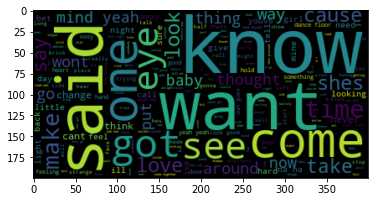

In [268]:
text = one_string_AM
stopwords = list(STOPWORDS) + ["youre", "im", "well", "oh", "wanna", "theres", "dont", "da"]
wordcloud = WordCloud(stopwords=stopwords).generate(text)

plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

------------

In [57]:
CORPUS

['i just wanted to be one of the strokes now look at the mess you made me make hitchhiking with a monogrammed suitcase miles away from any half-useful imaginary highway im a big name in deep space ask your mates but golden boys in bad shape i found out the hard way that here aint no place for dolls like you and me everybodys on a barge floating down the endless stream of great tv 1984 2019 maybe i was a little too wild in the 70s rocket-ship grease down the cracks of my knuckles karate bandana warp speed chic hair down to there impressive moustache love came in a bottle with a twist off cap lets all have a swig and do a hot lap so who you gonna call? the martini police baby that isnt how they look tonight oh no it took the light forever to get to your eyes i just wanted to be one of those ghosts you thought that you could forget and then i haunt you via the rear view mirror on a long drive from the back seat but its alright cause you love me and you recognize that it aint how',
 'it sh

In [58]:
# create labels for corpus list
LABELS = ["arctic monkeys"] * len(am) + ["cardi b"] * len(cb) + ["doja cat"] * len(dc) + ["frank ocean"] * len(fo) + ["kevin abstract"] * len(ka)
len(LABELS), LABELS

(891,
 ['arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monkeys',
  'arctic monk

In [59]:
corpus_labels = pd.DataFrame({"Artist" : LABELS, "Lyrics" : CORPUS})
corpus_labels

,Artist,Lyrics
0,arctic monkeys,i just wanted to be one of the strokes now loo...
1,arctic monkeys,it should be your eyes are heavy and the weath...
2,arctic monkeys,"did mr. winter wonderland say ""come here kid w..."
3,arctic monkeys,thought not in a million years that id meet so...
4,arctic monkeys,wants some answers do you remember where it al...
...,...,...
886,kevin abstract,all again known you for some time but it feels...
887,kevin abstract,my outlook thats why hes gorgeous your parents...
888,kevin abstract,baby if the trees were yellow that would cure ...
889,kevin abstract,quit my job the other day even though im in ne...


In [60]:
for row in range(len(corpus_labels)):
    corpus_labels.loc[row, "Lyrics"] = re.sub(r"[\[\]\(\)\"]","",corpus_labels.loc[row, "Lyrics"])
    corpus_labels.loc[row, "Lyrics"] = re.sub(r"[^a-zA-Z]"," ",corpus_labels.loc[row, "Lyrics"])

In [138]:
X = corpus_labels["Lyrics"]
y = corpus_labels.Artist

X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, shuffle=True, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((623,), (268,), (623,), (268,))

In [187]:
y_test.value_counts()

cardi b           84
frank ocean       59
arctic monkeys    57
doja cat          52
kevin abstract    16
Name: Artist, dtype: int64

### Model: Random Forest

In [215]:
tfidf = TfidfVectorizer(stop_words='english')
rf = RandomForestClassifier(n_estimators=45,max_depth=45)

In [216]:
X_trainvec = tfidf.fit_transform(X_train)
X_testvec = tfidf.transform(X_test)

In [217]:
rf.fit(X_trainvec,y_train)
rf.score(X_trainvec,y_train), rf.score(X_testvec,y_test)

(1.0, 0.7350746268656716)

### Gridsearch

In [182]:
rf = RandomForestClassifier()
grid = GridSearchCV(rf, {
    'n_estimators': range(30, 60, 5),
    'criterion': ["gini", "entropy", "log_loss"], 
    'max_depth': (range(20, 50, 5))
})

In [183]:
warnings.filterwarnings(action='ignore')

In [188]:
grid.fit(X_trainvec, y_train)
grid.score(X_testvec, y_test)

KeyboardInterrupt: 

In [181]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 50}

c:\Users\power\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


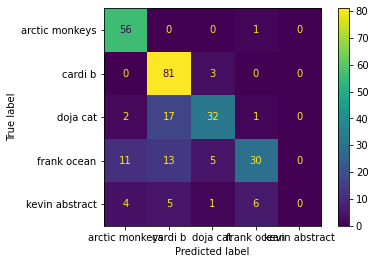

In [163]:
plot_confusion_matrix(rf,X_testvec,y_test)
plt.figure(figsize= 10,10)

In [144]:
cross_val_score(rf,X_trainvec,y_train,cv=KFold(shuffle=True))

array([0.736     , 0.672     , 0.8       , 0.79032258, 0.73387097])

### Naive Bayes

In [147]:
model = train_model(CORPUS, LABELS)

In [148]:
model.classes_

array(['arctic monkeys', 'cardi b', 'doja cat', 'frank ocean',
       'kevin abstract'], dtype='<U14')

In [149]:
predict(model, 'a tornado mess')

('frank ocean',
 array([[0.18655239, 0.26274419, 0.22972599, 0.26831235, 0.05266507]]))

### Balance the dataset

In [152]:
# check percentages of class in target
corpus_labels["Artist"].value_counts(normalize=True) * 100

# slightly imbalanced dataset

cardi b           31.425365
frank ocean       21.997755
arctic monkeys    21.324355
doja cat          19.191919
kevin abstract     6.060606
Name: Artist, dtype: float64

In [153]:
# check counts of class in target
corpus_labels["Artist"].value_counts()

cardi b           280
frank ocean       196
arctic monkeys    190
doja cat          171
kevin abstract     54
Name: Artist, dtype: int64

### RANDOM OVERSAMPLING:

In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy={'kevin abstract': 200}) 
X_train_ros, y_train_ros = ros.fit_resample(X_trainvec, y_train)
y_train_ros.value_counts()

kevin abstract    200
cardi b           196
frank ocean       137
arctic monkeys    133
doja cat          119
Name: Artist, dtype: int64

In [ ]:
rf.fit(X_train_ros, y_train_ros)
ypred_ros = rf.predict(X_testvec)
print_evaluations(y_test, ypred_ros, 'Random Oversampling')

### Synthetic Minority Oversampling

How does model SMOTE score:
Accuracy:0.75
Precision:0.782
Recall:0.75
F1:0.719
[[56  0  0  1  0]
 [ 0 83  1  0  0]
 [ 2 18 31  1  0]
 [10 16  3 30  0]
 [ 3  5  1  6  1]]


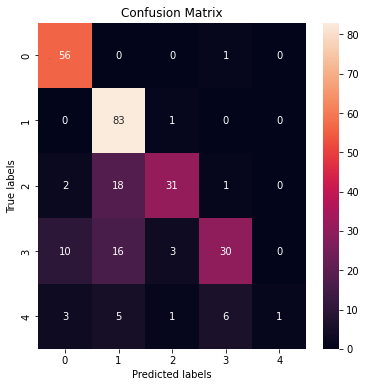

In [ ]:
sm = SMOTE(sampling_strategy={"kevin abstract": 200}, random_state=RANDOM_STATE)
X_train_smote, y_train_smote = sm.fit_resample(X_trainvec, y_train)
y_train_smote.value_counts()

rf.fit(X_train_smote, y_train_smote)
ypred_smote = rf.predict(X_testvec)

print_evaluations(y_test, ypred_smote, 'SMOTE')

### Testing models

How does model RandomForest score:
Accuracy:0.765
Precision:0.73
Recall:0.765
F1:0.733
[[54  0  1  2  0]
 [ 0 83  1  0  0]
 [ 1 16 35  0  0]
 [ 7 14  5 33  0]
 [ 3  5  3  5  0]]


c:\Users\power\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


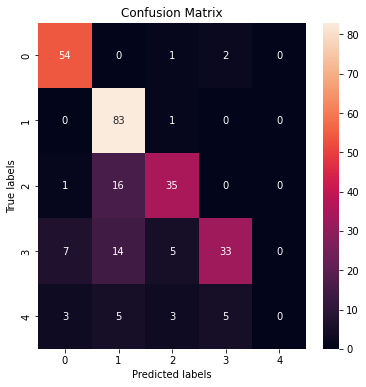

In [155]:
# RANDOM FOREST

rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf.fit(X_trainvec, y_train)
ypred_rf = rf.predict(X_testvec)
print_evaluations(y_test, ypred_rf, 'RandomForest')

# Accuracy:0.765
# Precision:0.73
# Recall:0.765
# F1:0.733

rf.fit(X_train_smote, y_train_smote)
ypred_rf = rf.predict(X_testvec)
print_evaluations(y_test, ypred_rf, 'RandomForest')

# Accuracy:0.735
# Precision:0.707
# Recall:0.735
# F1:0.697

How does model Logistic score:
Accuracy:0.843
Precision:0.851
Recall:0.843
F1:0.84
[[56  0  1  0  0]
 [ 0 74  8  2  0]
 [ 3  5 43  1  0]
 [ 5  7  3 44  0]
 [ 2  1  2  2  9]]
How does model Logistic_ROS score:
Accuracy:0.847
Precision:0.854
Recall:0.847
F1:0.844
[[56  0  1  0  0]
 [ 0 74  8  2  0]
 [ 2  5 44  1  0]
 [ 5  7  3 44  0]
 [ 2  1  2  2  9]]
How does model Logistic_SMOTE score:
Accuracy:0.843
Precision:0.85
Recall:0.843
F1:0.839
[[56  0  1  0  0]
 [ 0 74  8  2  0]
 [ 2  5 44  1  0]
 [ 5  7  3 44  0]
 [ 2  1  2  3  8]]


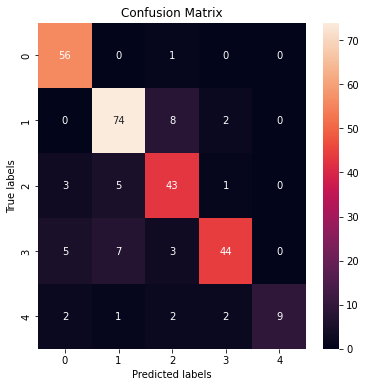

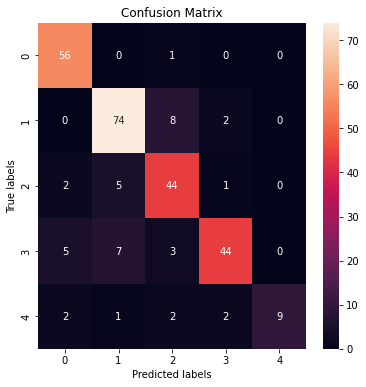

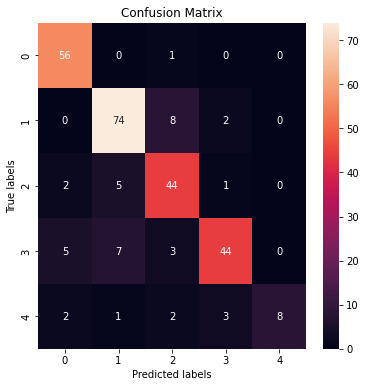

In [235]:
#LOGISTIC REGRESSION

lr = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000)

lr.fit(X_trainvec, y_train)
ypred_lr = lr.predict(X_testvec)

# evaluate
print_evaluations(y_test, ypred_lr, 'Logistic')

# Accuracy:0.843
# Precision:0.851
# Recall:0.843
# F1:0.84

lr.fit(X_train_ros, y_train_ros)
ypred_lr = lr.predict(X_testvec)

# evaluate
print_evaluations(y_test, ypred_lr, 'Logistic_ROS')

# Accuracy:0.847
# Precision:0.854
# Recall:0.847
# F1:0.844

lr.fit(X_train_smote, y_train_smote)
ypred_lr = lr.predict(X_testvec)

# evaluate
print_evaluations(y_test, ypred_lr, 'Logistic_SMOTE')

# Accuracy:0.843
# Precision:0.85
# Recall:0.843
# F1:0.839

In [253]:
# predict from corpus directly
pipeline = make_pipeline(TfidfVectorizer(stop_words='english'), 
LogisticRegression())
#pipeline.fit(CORPUS, LABELS)
pipeline.fit(CORPUS, LABELS)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('logisticregression', LogisticRegression())])

1) Arctic Monkeys
2) Cardi B
3) Doja Cat
4) Frank Ocean
5) Kevin Abstract

In [254]:
pipeline.predict_proba(['I thought I was dreaming']) # frank ocean songlyric

array([[0.29707413, 0.19826862, 0.07525692, 0.37492822, 0.0544721 ]])

## BAG of WORDS

In [ ]:
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1))

In [ ]:
vec = cv.fit_transform(corpus_labels["Lyrics"])

In [ ]:
vec.shape

(891, 9737)

In [ ]:
vec.todense().shape

(891, 9737)

In [ ]:
pd.DataFrame(vec.todense(), columns=cv.get_feature_names(), index=LABELS)

c:\Users\power\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,007,08,09,10,100s,10k,10s,11,12,15,...,就跟着她走,年轻又多金,当她出场全部都得让道,有着中国血统,独立的个性奠定了绝不受人摆布,目光被锁定,脚下踩着高跟,那你必须要超过,都围着她转,风靡全场
arctic monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arctic monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arctic monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arctic monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
arctic monkeys,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kevin abstract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kevin abstract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kevin abstract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kevin abstract,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
tf = TfidfTransformer()
vec2 = tf.fit_transform(vec)
pd.DataFrame(vec2.todense(), columns=cv.get_feature_names(), index=LABELS)

c:\Users\power\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,007,08,09,10,100s,10k,10s,11,12,15,...,就跟着她走,年轻又多金,当她出场全部都得让道,有着中国血统,独立的个性奠定了绝不受人摆布,目光被锁定,脚下踩着高跟,那你必须要超过,都围着她转,风靡全场
arctic monkeys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arctic monkeys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arctic monkeys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arctic monkeys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
arctic monkeys,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
kevin abstract,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kevin abstract,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kevin abstract,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
kevin abstract,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(CORPUS)
m = RandomForestClassifier(max_depth=40)
m.fit(X, LABELS)
m.score(X, LABELS)

1.0

In [ ]:
c = Counter(vectorizer.vocabulary_)
most_occur = c.most_common(50)
pd.DataFrame(most_occur)

,0,1
0,风靡全场,9736
1,都围着她转,9735
2,那你必须要超过,9734
3,脚下踩着高跟,9733
4,目光被锁定,9732
5,独立的个性奠定了绝不受人摆布,9731
6,有着中国血统,9730
7,当她出场全部都得让道,9729
8,年轻又多金,9728
9,就跟着她走,9727


In [ ]:
# predict
pipeline = make_pipeline(TfidfVectorizer(stop_words='english'), 
RandomForestClassifier(max_depth=5))
pipeline.fit(CORPUS, LABELS)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5))])

1) Arctic Monkeys
2) Cardi B
3) Doja Cat
4) Frank Ocean
5) Kevin Abstract

In [ ]:
pipeline.predict_proba(['doja cat']) #doja cat songlyric

array([[0.23674353, 0.26266643, 0.19090094, 0.24469811, 0.06499099]])

In [1]:
pipeline.predict_proba(['i thought that i was dreaming']) # frank ocean songlyric

NameError: name 'pipeline' is not defined